In [1]:
# Importing packages
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, sampler
from torchsummary import summary

import copy
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

import cv2
import numpy as np
from PIL import Image, ImageFilter, ImageEnhance, ImageDraw

## Define functions

In [2]:
def add_gaussian_noise(img, mean=0, std=20):
    # Create Gaussian noise
    noise = np.random.normal(mean, std, img.shape)

    # Apply the noise to the input image
    img_gn = np.zeros(img.shape)
    for i in range(img.shape[2]):
        img_gn[:, :, i] = np.clip(img[:, :, i] + noise[:, :, i], 0, 255)

    return img_gn.astype(np.uint8)

def add_shot_noise(img, lam=100):
  
    # Create Poisson noise
    noise = np.random.poisson(lam, img.shape)

    # Apply the noise to the input image
    img_sn = np.zeros(img.shape)
    for i in range(img.shape[2]):
        img_sn[:, :, i] = np.clip(img[:, :, i] + noise[:, :, i], 0, 255)

    return img_sn.astype(np.uint8)

# Create rotation function 
def rotate(image, degree=1):
    reshape = np.transpose(image, (1, 2, 0))
    rot_image = np.rot90(reshape, degree)
    return torch.Tensor(np.transpose(rot_image, (2, 0, 1)).copy())

# Define my dataset
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [3]:
# Define the device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
# Define transformations 
transform = transforms.Compose([
    transforms.RandomCrop(96, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Load the dataset
testset = datasets.STL10(root='../datasets', split='test', download=False, transform=transform)

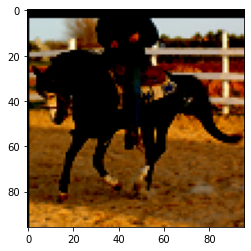

In [212]:
plt.imshow(np.transpose(testset[0][0], (1, 2, 0)))
plt.savefig('normal.png')

In [80]:
testloader = DataLoader(testset, batch_size=20, num_workers=2, shuffle=True)

### Add Gaussian Noise

In [102]:
# Define a custom transform to add Gaussian noise to the images
class Gaussian_Noise(object):
    def __init__(self, mean=0., std=1.):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

transform_g = transforms.Compose([
    transforms.RandomCrop(96, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    Gaussian_Noise(0., 0.3),
])

In [103]:
# Load the dataset
testset_g = datasets.STL10(root='../datasets', split='test', download=False, transform=transform_g)

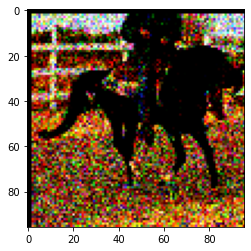

In [213]:
plt.imshow(np.transpose(testset_g[0][0], (1, 2, 0)))
plt.savefig('Gaussiannoise.png')

In [106]:
testloader_g = DataLoader(testset_g, batch_size=10, num_workers=2, shuffle=True)

### Add shot noise

In [120]:
class Shot_Noise(object):
    def __init__(self, rate):
        self.rate = rate

    def __call__(self, tensor):
        return tensor + torch.poisson(tensor * self.rate) / self.rate

transform_s = transforms.Compose([
    transforms.RandomCrop(96, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    Gaussian_Noise(0.02),
])

In [121]:
# Load the dataset
testset_s = datasets.STL10(root='../datasets', split='test', download=False, transform=transform_s)

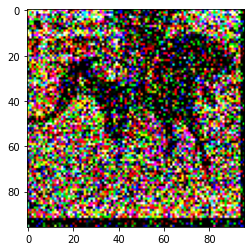

In [214]:
plt.imshow(np.transpose(testset_s[0][0], (1, 2, 0)))
plt.savefig('shotnoise.png')

In [123]:
testloader_s = DataLoader(testset_s, batch_size=10, num_workers=2, shuffle=True)

### Add Gaussian blur

In [135]:
transform_gb = transforms.Compose([
    transforms.RandomCrop(96, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.GaussianBlur(kernel_size=7),
])

In [136]:
# Load the dataset
testset_gb = datasets.STL10(root='../datasets', split='test', download=False, transform=transform_gb)

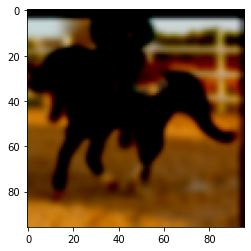

In [216]:
plt.imshow(np.transpose(testset_gb[0][0], (1, 2, 0)))
plt.savefig('Gaussianblur.png')

In [138]:
testloader_gb = DataLoader(testset_gb, batch_size=10, num_workers=2, shuffle=True)

### Brightness increase

In [170]:
transform_cj = transforms.Compose([
    transforms.RandomCrop(96, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.ColorJitter(brightness=(1.8, 2))
])

In [171]:
# Load the dataset
testset_cj = datasets.STL10(root='../datasets', split='test', download=False, transform=transform_cj)

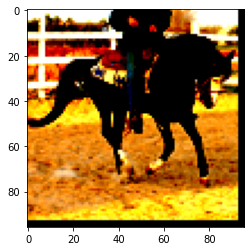

In [217]:
plt.imshow(np.transpose(testset_cj[0][0], (1, 2, 0)))
plt.savefig('brightness.png')

In [173]:
testloader_cj = DataLoader(testset_cj, batch_size=10, num_workers=2, shuffle=True)

### Hue change

In [178]:
transform_cj2 = transforms.Compose([
    transforms.RandomCrop(96, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.ColorJitter(hue=(0, 0.3))
])

In [182]:
# Load the dataset
testset_cj2 = datasets.STL10(root='../datasets', split='test', download=False, transform=transform_cj2)

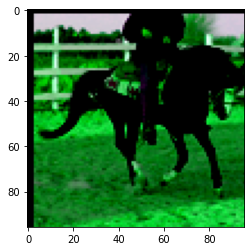

In [218]:
plt.imshow(np.transpose(testset_cj2[0][0], (1, 2, 0)))
plt.savefig('hue.png')

In [184]:
testloader_cj2 = DataLoader(testset_cj2, batch_size=10, num_workers=2, shuffle=True)

### Contrast

In [200]:
transform_cj3 = transforms.Compose([
    transforms.RandomCrop(96, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.ColorJitter(contrast=(0.5, 0.7))
])

In [201]:
# Load the dataset
testset_cj3 = datasets.STL10(root='../datasets', split='test', download=False, transform=transform_cj3)

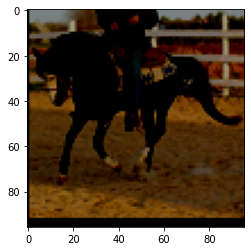

In [219]:
plt.imshow(np.transpose(testset_cj3[0][0], (1, 2, 0)))
plt.savefig('contrast.png')

In [203]:
testloader_cj3 = DataLoader(testset_cj3, batch_size=10, num_workers=2, shuffle=True)

## Load models

In [6]:
class ResBlock(nn.Module):
    def __init__(self, in_channel, out_channel, stride=1, num_block=1):
        super(ResBlock, self).__init__()
        self.num_block = num_block
        self.layers = nn.ModuleList([])
        
        self.layers.append(nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=1, stride=stride)
        ))
        self.layers.append(nn.Sequential  (
            nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1, stride=stride),
#             nn.GroupNorm(out_channel//4, out_channel),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1, stride=1),
            nn.GroupNorm(out_channel//4, out_channel),
            nn.ReLU(inplace=True)
        ))
        
        for _ in range(1, num_block):
            self.layers.append(nn.Sequential(
                nn.Conv2d(out_channel, out_channel, kernel_size=1, stride=1)
            ))
            self.layers.append(nn.Sequential(
                nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1, stride=1),
#                 nn.GroupNorm(out_channel//4, out_channel),
                nn.BatchNorm2d(out_channel),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1, stride=1),
#                 nn.GroupNorm(out_channel//4, out_channel),
                nn.BatchNorm2d(out_channel),
                nn.ReLU(inplace=True)
            ))
    
    def forward(self, x):
        for i in range(self.num_block):
            x_identity = self.layers[2*i](x)
            x = self.layers[2*i+1](x)
            x = F.relu(x + x_identity, inplace=True) 
        
        return x

class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, stride=1, padding=1)
#         self.gn1 = nn.GroupNorm(4, 16)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.layers1 = ResBlock(32, 32, num_block=4)
        self.layers2 = ResBlock(32, 64, stride=2, num_block=2)
        self.layers3 = ResBlock(64, 128, stride=2, num_block=2)
        self.layers4 = ResBlock(128, 256, stride=2, num_block=2)
        
        self.avgpool1 = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(256, 10)
          
    def forward(self, x, theta = None):
        x = self.conv1(x)
#         x = self.gn1(x)
        x = self.bn1(x)
        x = F.relu(x, inplace=True)
        x = self.layers1(x)
        x = self.layers2(x)
        
        x1 = self.layers3(x)
        x1 = self.layers4(x1)
        x1 = self.avgpool1(x1)
        x1 = x1.view(-1, 256)
        x1 = self.fc1(x1)
        
        return x1


class JointResNet(nn.Module):
    def __init__(self):
        super(JointResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, stride=1, padding=1)
#         self.gn1 = nn.GroupNorm(4, 16)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.layers1 = ResBlock(64, 64, num_block=2)
        self.layers2 = ResBlock(64, 128, stride=2, num_block=2)
        self.layers3 = ResBlock(128, 256, stride=2, num_block=2)
        self.layers4_1 = ResBlock(256, 512, stride=2, num_block=2)
        self.layers4_2 = ResBlock(256, 512, stride=2, num_block=2)
        
        self.avgpool1 = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(512, 10)
        
        self.avgpool2 = nn.AdaptiveAvgPool2d((1, 1))
        self.fc2 = nn.Linear(512, 4)
        
        
    def forward(self, x, theta = None):
        x = self.conv1(x)
#         x = self.gn1(x)
        x = self.bn1(x)
        x = F.relu(x, inplace=True)
        x = self.layers1(x)
        x = self.layers2(x)
        x = self.layers3(x)
        
        x1 = self.layers4_1(x)
        x1 = self.avgpool1(x1)
        x1 = x1.view(-1, 512)
        x1 = self.fc1(x1)
        
        x2 = self.layers4_2(x)
        x2 = self.avgpool2(x2)
        x2 = x2.view(-1, 512)
        x2 = self.fc2(x2)
        return x1, x2  

In [112]:
model1 = ResNet().to(device)
checkpoint = torch.load('models/stl_resnet.pt')
model1.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [7]:
# Define the loss functions
criterion1 = nn.CrossEntropyLoss()
criterion2 = nn.CrossEntropyLoss()

# Initialize the model and define optimizer
model2 = JointResNet().to(device)

In [8]:
# load the saved model
checkpoint = torch.load('models/stl_jointresnet.pt')
model2.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [45]:
import copy
model3 = copy.deepcopy(model2).to(device)

In [46]:
theta_e = list(model3.conv1.parameters()) + list(model3.bn1.parameters()) + list(model3.layers1.parameters()) + \
            list(model3.layers2.parameters()) + list(model3.layers3.parameters())
optimizer = optim.SGD(theta_e, lr=0.0001, momentum=0, weight_decay=0)

## Test time training

### Normal test set

In [113]:
# Compute the accuracy on the test set
correct = 0
total = 0

for i, (images, labels) in enumerate(testloader):
    images, labels = images.to(device), labels.to(device)
    
    with torch.no_grad():
        out1 = model1(images)

        # Compute the accuracy for branch
        _, predicted = torch.max(out1.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

print('Accuracy for image classification (ResNet): {:.2f} %'.format(100 * correct / total))

Accuracy for image classification (ResNet): 70.88 %


In [125]:
# Compute the accuracy on the test set
correct = 0
total = 0

for i, (images, labels) in enumerate(testloader):
    images, labels = images.to(device), labels.to(device)
    
    with torch.no_grad():
        out1, _ = model2(images)

        # Compute the accuracy for branch
        _, predicted = torch.max(out1.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

print('Accuracy for image classification (Joint net): {:.2f} %'.format(100 * correct / total))

Accuracy for image classification (Joint net): 58.38 %


In [124]:
# Compute the accuracy on the test set
correct = 0
total = 0

for i, (images, labels) in enumerate(testloader):   
    X_new = []
    y_new = []

    for (x, y) in zip(images, labels):
        for _ in range(1):
            deg = np.random.randint(0, 4)
            X_new.append(rotate(x.numpy(), deg))
            y_new.append(deg)
            
    stacked_x = torch.stack(X_new).to(device)
    stacked_y = torch.tensor(y_new).to(device)

    for _ in range(1):
        # Forward pass
        optimizer.zero_grad()
        _, out2 = model3(stacked_x)

        # Compute loss
        loss = criterion1(out2, stacked_y)

        # Back propagation
        loss.backward()
        optimizer.step()

    images, labels = images.to(device), labels.to(device)
    out1, _ = model3(images)

    # Compute the accuracy for branch
    _, predicted = torch.max(out1.data, 1)
    correct += (predicted == labels).sum().item()
    total += labels.size(0)

print('Accuracy for image classification (TTT): {:.2f} %'.format(100 * correct / total))

Accuracy for image classification (TTT): 58.21 %


### Gaussian noise

In [114]:
# Compute the accuracy on the test set
correct = 0
total = 0

for i, (images, labels) in enumerate(testloader_g):
    images, labels = images.to(device), labels.to(device)
    
    with torch.no_grad():
        out1 = model1(images)

        # Compute the accuracy for branch
        _, predicted = torch.max(out1.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

print('Accuracy for image classification (ResNet): {:.2f} %'.format(100 * correct / total))

Accuracy for image classification (ResNet): 61.09 %


In [107]:
# Compute the accuracy on the test set
correct = 0
total = 0

for i, (images, labels) in enumerate(testloader_g):
    images, labels = images.to(device), labels.to(device)
    
    with torch.no_grad():
        out1, _ = model2(images)

        # Compute the accuracy for branch
        _, predicted = torch.max(out1.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

print('Accuracy for image classification: {:.2f} %'.format(100 * correct / total))

Accuracy for image classification: 49.95 %


In [210]:
model3 = copy.deepcopy(model2).to(device)
theta_e = list(model3.conv1.parameters()) + list(model3.bn1.parameters()) + list(model3.layers1.parameters()) + \
            list(model3.layers2.parameters()) + list(model3.layers3.parameters())
optimizer = optim.SGD(theta_e, lr=0.0001, momentum=0, weight_decay=0)

In [211]:
# Compute the accuracy on the test set
correct = 0
total = 0

for i, (images, labels) in enumerate(testloader_g):   
    X_new = []
    y_new = []

    for (x, y) in zip(images, labels):
        for i in range(1):
            deg = np.random.randint(0, 4)
            X_new.append(rotate(x.numpy(), deg))
            y_new.append(deg)
            
    stacked_x = torch.stack(X_new).to(device)
    stacked_y = torch.tensor(y_new).to(device)
            
    for _ in range(1):
        # Forward pass
        optimizer.zero_grad()
        _, out2 = model3(stacked_x)

        # Compute loss
        loss = criterion1(out2, stacked_y)

        # Back propagation
        loss.backward()
        optimizer.step()
    
    images, labels = images.to(device), labels.to(device)
    out1, _ = model3(images)

    # Compute the accuracy for branch
    _, predicted = torch.max(out1.data, 1)
    correct += (predicted == labels).sum().item()
    total += labels.size(0)

print('Accuracy for image classification (TTT): {:.2f} %'.format(100 * correct / total))

Accuracy for image classification (TTT): 50.02 %


### Shot noise

In [126]:
# Compute the accuracy on the test set
correct = 0
total = 0

for i, (images, labels) in enumerate(testloader_s):
    images, labels = images.to(device), labels.to(device)
    
    with torch.no_grad():
        out1 = model1(images)

        # Compute the accuracy for branch
        _, predicted = torch.max(out1.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

print('Accuracy for image classification (ResNet): {:.2f} %'.format(100 * correct / total))

Accuracy for image classification (ResNet): 41.65 %


In [129]:
# Compute the accuracy on the test set
correct = 0
total = 0

for i, (images, labels) in enumerate(testloader_s):
    images, labels = images.to(device), labels.to(device)
    
    with torch.no_grad():
        out1, _ = model2(images)

        # Compute the accuracy for branch
        _, predicted = torch.max(out1.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

print('Accuracy for image classification (Joint net): {:.2f} %'.format(100 * correct / total))

Accuracy for image classification (Joint net): 33.27 %


In [208]:
model3 = copy.deepcopy(model2).to(device)
theta_e = list(model3.conv1.parameters()) + list(model3.bn1.parameters()) + list(model3.layers1.parameters()) + \
            list(model3.layers2.parameters()) + list(model3.layers3.parameters())
optimizer = optim.SGD(theta_e, lr=0.0001, momentum=0, weight_decay=0)

In [209]:
# Compute the accuracy on the test set
correct = 0
total = 0

for i, (images, labels) in enumerate(testloader_s):   
    X_new = []
    y_new = []

    for (x, y) in zip(images, labels):
        for i in range(1):
            deg = np.random.randint(0, 4)
            X_new.append(rotate(x.numpy(), deg))
            y_new.append(deg)
            
    stacked_x = torch.stack(X_new).to(device)
    stacked_y = torch.tensor(y_new).to(device)
            
    for _ in range(1):
        # Forward pass
        optimizer.zero_grad()
        _, out2 = model3(stacked_x)

        # Compute loss
        loss = criterion1(out2, stacked_y)

        # Back propagation
        loss.backward()
        optimizer.step()
    
    images, labels = images.to(device), labels.to(device)
    out1, _ = model3(images)

    # Compute the accuracy for branch
    _, predicted = torch.max(out1.data, 1)
    correct += (predicted == labels).sum().item()
    total += labels.size(0)

print('Accuracy for image classification (TTT): {:.2f} %'.format(100 * correct / total))

Accuracy for image classification (TTT): 32.95 %


### Gaussian blur

In [139]:
# Compute the accuracy on the test set
correct = 0
total = 0

for i, (images, labels) in enumerate(testloader_gb):
    images, labels = images.to(device), labels.to(device)
    
    with torch.no_grad():
        out1 = model1(images)

        # Compute the accuracy for branch
        _, predicted = torch.max(out1.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

print('Accuracy for image classification (ResNet): {:.2f} %'.format(100 * correct / total))

Accuracy for image classification (ResNet): 62.21 %


In [140]:
# Compute the accuracy on the test set
correct = 0
total = 0

for i, (images, labels) in enumerate(testloader_gb):
    images, labels = images.to(device), labels.to(device)
    
    with torch.no_grad():
        out1, _ = model2(images)

        # Compute the accuracy for branch
        _, predicted = torch.max(out1.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

print('Accuracy for image classification (Joint net): {:.2f} %'.format(100 * correct / total))

Accuracy for image classification (Joint net): 52.24 %


In [142]:
model3 = copy.deepcopy(model2).to(device)
theta_e = list(model3.conv1.parameters()) + list(model3.bn1.parameters()) + list(model3.layers1.parameters()) + \
            list(model3.layers2.parameters()) + list(model3.layers3.parameters())
optimizer = optim.SGD(theta_e, lr=0.0001, momentum=0, weight_decay=0)

In [143]:
# Compute the accuracy on the test set
correct = 0
total = 0

for i, (images, labels) in enumerate(testloader_gb):   
    X_new = []
    y_new = []

    for (x, y) in zip(images, labels):
        for i in range(1):
            deg = np.random.randint(0, 4)
            X_new.append(rotate(x.numpy(), deg))
            y_new.append(deg)
            
    stacked_x = torch.stack(X_new).to(device)
    stacked_y = torch.tensor(y_new).to(device)
            
    for _ in range(1):
        # Forward pass
        optimizer.zero_grad()
        _, out2 = model3(stacked_x)

        # Compute loss
        loss = criterion1(out2, stacked_y)

        # Back propagation
        loss.backward()
        optimizer.step()
    
    images, labels = images.to(device), labels.to(device)
    out1, _ = model3(images)

    # Compute the accuracy for branch
    _, predicted = torch.max(out1.data, 1)
    correct += (predicted == labels).sum().item()
    total += labels.size(0)

print('Accuracy for image classification (TTT): {:.2f} %'.format(100 * correct / total))

Accuracy for image classification (TTT): 51.09 %


### Brightness

In [174]:
# Compute the accuracy on the test set
correct = 0
total = 0

for i, (images, labels) in enumerate(testloader_cj):
    images, labels = images.to(device), labels.to(device)
    
    with torch.no_grad():
        out1 = model1(images)

        # Compute the accuracy for branch
        _, predicted = torch.max(out1.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

print('Accuracy for image classification (ResNet): {:.2f} %'.format(100 * correct / total))

Accuracy for image classification (ResNet): 43.30 %


In [175]:
# Compute the accuracy on the test set
correct = 0
total = 0

for i, (images, labels) in enumerate(testloader_cj):
    images, labels = images.to(device), labels.to(device)
    
    with torch.no_grad():
        out1, _ = model2(images)

        # Compute the accuracy for branch
        _, predicted = torch.max(out1.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

print('Accuracy for image classification (Joint net): {:.2f} %'.format(100 * correct / total))

Accuracy for image classification (Joint net): 36.55 %


In [176]:
model3 = copy.deepcopy(model2).to(device)
theta_e = list(model3.conv1.parameters()) + list(model3.bn1.parameters()) + list(model3.layers1.parameters()) + \
            list(model3.layers2.parameters()) + list(model3.layers3.parameters())
optimizer = optim.SGD(theta_e, lr=0.0001, momentum=0, weight_decay=0)

In [177]:
# Compute the accuracy on the test set
correct = 0
total = 0

for i, (images, labels) in enumerate(testloader_cj):   
    X_new = []
    y_new = []

    for (x, y) in zip(images, labels):
        for i in range(1):
            deg = np.random.randint(0, 4)
            X_new.append(rotate(x.numpy(), deg))
            y_new.append(deg)
            
    stacked_x = torch.stack(X_new).to(device)
    stacked_y = torch.tensor(y_new).to(device)
            
    for _ in range(1):
        # Forward pass
        optimizer.zero_grad()
        _, out2 = model3(stacked_x)

        # Compute loss
        loss = criterion1(out2, stacked_y)

        # Back propagation
        loss.backward()
        optimizer.step()
    
    images, labels = images.to(device), labels.to(device)
    out1, _ = model3(images)

    # Compute the accuracy for branch
    _, predicted = torch.max(out1.data, 1)
    correct += (predicted == labels).sum().item()
    total += labels.size(0)

print('Accuracy for image classification (TTT): {:.2f} %'.format(100 * correct / total))

Accuracy for image classification (TTT): 37.34 %


### Hue change

In [185]:
# Compute the accuracy on the test set
correct = 0
total = 0

for i, (images, labels) in enumerate(testloader_cj2):
    images, labels = images.to(device), labels.to(device)
    
    with torch.no_grad():
        out1 = model1(images)

        # Compute the accuracy for branch
        _, predicted = torch.max(out1.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

print('Accuracy for image classification (ResNet): {:.2f} %'.format(100 * correct / total))

Accuracy for image classification (ResNet): 48.11 %


In [186]:
# Compute the accuracy on the test set
correct = 0
total = 0

for i, (images, labels) in enumerate(testloader_cj2):
    images, labels = images.to(device), labels.to(device)
    
    with torch.no_grad():
        out1, _ = model2(images)

        # Compute the accuracy for branch
        _, predicted = torch.max(out1.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

print('Accuracy for image classification (Joint net): {:.2f} %'.format(100 * correct / total))

Accuracy for image classification (Joint net): 39.61 %


In [187]:
model3 = copy.deepcopy(model2).to(device)
theta_e = list(model3.conv1.parameters()) + list(model3.bn1.parameters()) + list(model3.layers1.parameters()) + \
            list(model3.layers2.parameters()) + list(model3.layers3.parameters())
optimizer = optim.SGD(theta_e, lr=0.0001, momentum=0, weight_decay=0)

In [188]:
# Compute the accuracy on the test set
correct = 0
total = 0

for i, (images, labels) in enumerate(testloader_cj2):   
    X_new = []
    y_new = []

    for (x, y) in zip(images, labels):
        for i in range(1):
            deg = np.random.randint(0, 4)
            X_new.append(rotate(x.numpy(), deg))
            y_new.append(deg)
            
    stacked_x = torch.stack(X_new).to(device)
    stacked_y = torch.tensor(y_new).to(device)
            
    for _ in range(1):
        # Forward pass
        optimizer.zero_grad()
        _, out2 = model3(stacked_x)

        # Compute loss
        loss = criterion1(out2, stacked_y)

        # Back propagation
        loss.backward()
        optimizer.step()
    
    images, labels = images.to(device), labels.to(device)
    out1, _ = model3(images)

    # Compute the accuracy for branch
    _, predicted = torch.max(out1.data, 1)
    correct += (predicted == labels).sum().item()
    total += labels.size(0)

print('Accuracy for image classification (TTT): {:.2f} %'.format(100 * correct / total))

Accuracy for image classification (TTT): 39.84 %


### Contrast change

In [204]:
# Compute the accuracy on the test set
correct = 0
total = 0

for i, (images, labels) in enumerate(testloader_cj3):
    images, labels = images.to(device), labels.to(device)
    
    with torch.no_grad():
        out1 = model1(images)

        # Compute the accuracy for branch
        _, predicted = torch.max(out1.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

print('Accuracy for image classification (ResNet): {:.2f} %'.format(100 * correct / total))

Accuracy for image classification (ResNet): 36.96 %


In [205]:
# Compute the accuracy on the test set
correct = 0
total = 0

for i, (images, labels) in enumerate(testloader_cj3):
    images, labels = images.to(device), labels.to(device)
    
    with torch.no_grad():
        out1, _ = model2(images)

        # Compute the accuracy for branch
        _, predicted = torch.max(out1.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

print('Accuracy for image classification (Joint net): {:.2f} %'.format(100 * correct / total))

Accuracy for image classification (Joint net): 31.11 %


In [206]:
model3 = copy.deepcopy(model2).to(device)
theta_e = list(model3.conv1.parameters()) + list(model3.bn1.parameters()) + list(model3.layers1.parameters()) + \
            list(model3.layers2.parameters()) + list(model3.layers3.parameters())
optimizer = optim.SGD(theta_e, lr=0.0001, momentum=0, weight_decay=0)

In [207]:
# Compute the accuracy on the test set
correct = 0
total = 0

for i, (images, labels) in enumerate(testloader_cj2):   
    X_new = []
    y_new = []

    for (x, y) in zip(images, labels):
        for i in range(1):
            deg = np.random.randint(0, 4)
            X_new.append(rotate(x.numpy(), deg))
            y_new.append(deg)
            
    stacked_x = torch.stack(X_new).to(device)
    stacked_y = torch.tensor(y_new).to(device)
            
    for _ in range(1):
        # Forward pass
        optimizer.zero_grad()
        _, out2 = model3(stacked_x)

        # Compute loss
        loss = criterion1(out2, stacked_y)

        # Back propagation
        loss.backward()
        optimizer.step()
    
    images, labels = images.to(device), labels.to(device)
    out1, _ = model3(images)

    # Compute the accuracy for branch
    _, predicted = torch.max(out1.data, 1)
    correct += (predicted == labels).sum().item()
    total += labels.size(0)

print('Accuracy for image classification (TTT): {:.2f} %'.format(100 * correct / total))

Accuracy for image classification (TTT): 39.48 %
